# Dealing with Text for ML

Spring 2018 - Profs. Foster Provost and Josh Attenberg

Teaching Assistant: Apostolos Filippas

***



In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import sys

import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

np.random.seed(36)

sys.path.append("..")

from ds_utils.spam_data import load_spam_ham
from ds_utils.features_pipeline_3 import pipeline_from_config

### Data
For this class, we have a new data set comtaining a number of messages, some are spam, others are genuine non-spam (ham). Let's load it and take a look:

In [2]:
spam_df = load_spam_ham()
spam_df.head(2)

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham


In [3]:
spam_df["text"][:2].values

array(['Hi...I have to use R to find out the 90% confidence-interval for the sensitivityand specificity of the following diagnostic test:A particular diagnostic test for multiple sclerosis was conducted on 20 MSpatients and 20 healthy subjects, 6 MS patients were classified as healthyand 8 healthy subjects were classified as suffering from the MS.Furthermore, I need to find the number of MS patients required for asensitivity of 1%...Is there a simple R-command which can do that for me?I am completely new to R...Help please!Jochen-- View this message in context: http://www.nabble.com/Confidence-Intervals....-help...-tf3544217.html#a9894014Sent from the R help mailing list archive at Nabble.com.______________________________________________R-help@stat.math.ethz.ch mailing listhttps://stat.ethz.ch/mailman/listinfo/r-helpPLEASE do read the posting guide http://www.R-project.org/posting-guide.html',
       'Francesco Poli wrote:> On Sun, 15 Apr 2007 21:24:00 +0200 Arnoud Engelfriet wrote:> 

Looks like we have two features: some text (looks like an email). The input also has a label column (spam) What is the distribution of the target variable?

In [4]:
spam_df["spam"].value_counts()

ham     4864
spam    3246
Name: spam, dtype: int64

Here, the target is whether or not a record should be considered as spam. This is recorded as the string 'spam' or 'ham'. To make it a little easier for our classifier, let's recode it as `0` or `1`.

In [5]:
def is_spam(label):
    return 1 if label == "spam" else 0

labels = spam_df["spam"].apply(is_spam)
labels.value_counts()

0    4864
1    3246
Name: spam, dtype: int64

Since we are going to do some modeling, we should split our data into a training and test set.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spam_df["text"], labels, train_size=0.75, test_size=0.25)

### Text as features
How can we turn the large amount of text for each record into useful features?


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. You can do this in sklearn with a `CountVectorizer()` and setting `binary` to `true`. The process is very similar to how you fit a model: you will fit a `CounterVectorizer()`. This will figure out what words exist in your data.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [8]:
vocabulary_list = list(zip( binary_vectorizer.vocabulary_.keys(), binary_vectorizer.vocabulary_.values()) )

vocabulary_list[0:10]

[('chorowski', 19264),
 ('transferring', 63798),
 ('françois', 29434),
 ('disturbed', 24606),
 ('157', 2570),
 ('installi', 35121),
 ('imatinib', 34058),
 ('siempre', 56099),
 ('gamers', 30089),
 ('disadvantages', 24281)]

Now that we know what words are in the data, we can transform our blobs of text into a clean matrix. Simply `.transform()` the raw data using our fitted `CountVectorizer()`. You will do this for the training and test data. What do you think happens if there are new words in the test data that were not seen in the training data?

In [9]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_counts`.

In [10]:
X_test_binary

<2028x71157 sparse matrix of type '<class 'numpy.int64'>'
	with 225416 stored elements in Compressed Sparse Row format>

Sparse matrix? Where is our data?

If you look at the output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is ~2k rows long and ~70k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are ~140,000,000 cells that should have values. However, from the above, we can see that only ~220,000 cells (~0.15%) of the cells have values! Why is this?

To save space, sklearn sometimes uses a sparse matrix. This means that only values that are not zero are stored! This saves a ton of space! This also means that visualizing the data is a little trickier. Let's look at a very small chunk.

In [11]:
X_test_binary[0:20, 0:20].todense()

matrix([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0,

#### Applying a model
Now that we have a ton of features (since we have a ton of words!) let's try using a logistic regression model to predict spam/ham.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

binary_lr = LogisticRegression()
binary_lr.fit(X_train_binary, y_train)

binary_model_predictions = binary_lr.predict_proba(X_test_binary)[:,1]
binary_model_auc = roc_auc_score(y_test, binary_model_predictions)

print ("Area under the ROC curve on test data = %.3f" % binary_model_auc)

Area under the ROC curve on test data = 1.000


Is this any good? What do we care about in this case? Let's take a look at our ROC measure in more detail by looking at the actual ROC curve.

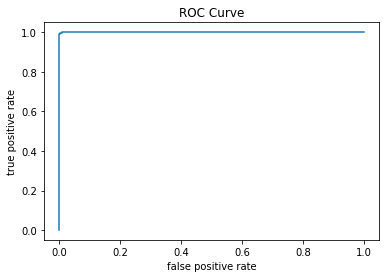

In [13]:
from sklearn.metrics import roc_curve
binary_model_fpr, binary_model_tpr, thresholds = roc_curve(y_test, binary_model_predictions)

ax = plt.subplot()
plt.plot(binary_model_fpr, binary_model_tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.show()

 **Yikes! That looks perfect.  Let's zoom in!**


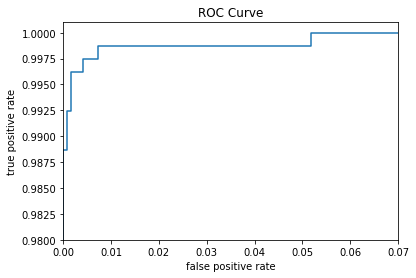

In [14]:
plt.plot(binary_model_fpr, binary_model_tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.xlim([0, .07])
plt.ylim([.98, 1.001])
plt.show()

Very good indeed!

** Aside: ** The `LogisticRegression` function in sklearn loads all the training data into memory and applies mathematical optimization techniques to set the parameters that minimize the loss over the training data. Consequence: this can be slow in some cases, and in cases where the training data is very large, it might lead to out of memory errors or issues with "paging".

There is an alternative implementation to `LogisticRegression`, the [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier). `SGDClassifier` loads examples from the training data in small batches. For each batch of training data, a small "optimization step" is performed where the model parameters are pushed towards value that reduces the loss over that batch. Consequence: extremely large volumes of training data can be consumed, and with some tweaking, "streaming" problems can be handled. The downside is, in the best case (small problems), vanilla `LogisticRegression` may converge more quickly, and may get closer to the best possible solution, as `SGDClassifier` performs iterative approximations.

In [15]:
from sklearn.linear_model import SGDClassifier

# sgd classifier can minimize a number of losses.
# loss = "log" is a logistic regression
binary_sgd_lr = SGDClassifier(loss="log", max_iter=1000, tol=0.000001)

binary_sgd_lr.fit(X_train_binary, y_train)

binary_sgd_model_predictions = binary_sgd_lr.predict_proba(X_test_binary)[:,1]
binary_sgd_model_auc = roc_auc_score(y_test, binary_sgd_model_predictions)

print ("Area under the ROC curve on test data = %.3f" % binary_sgd_model_auc)

Area under the ROC curve on test data = 1.000


#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

In [16]:
# Fit a counter (leave the default binary flag, which is false)
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
count_lr = LogisticRegression()
count_lr.fit(X_train_counts, y_train)

count_predictions = count_lr.predict_proba(X_test_counts)[:,1]
count_model_auc = roc_auc_score(y_test, count_predictions)

print ("Area under the ROC curve on test data = %.3f" % count_model_auc)

Area under the ROC curve on test data = 1.000


We can also take a look at the ROC curve.

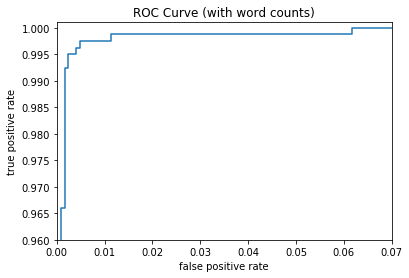

In [17]:
count_model_fpr, count_model_tpr, thresholds = roc_curve(y_test, count_predictions)

plt.plot(count_model_fpr, count_model_tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve (with word counts)")
plt.xlim([0, .07])
plt.ylim([.96, 1.001])

plt.show()

#### Tf-idf
Another popular technique when dealing with text is to use the term frequency - inverse document frequency (tf-idf) measure instead of just counts as the feature values (see text).

In [18]:
# Fit a counter
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
tfidf_model = LogisticRegression()
tfidf_model.fit(X_train_tfidf, y_train)

tfidf_predictions = tfidf_model.predict_proba(X_test_tfidf)[:,1]
tfidf_auc = roc_auc_score(y_test, tfidf_predictions)

print ("Area under the ROC curve on test data = %.3f" % tfidf_auc)

Area under the ROC curve on test data = 1.000


Once again, we can look at the ROC curve.

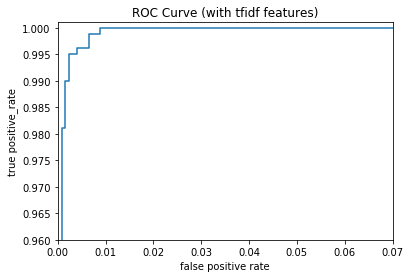

In [19]:
tfidf_fpr, tfidf_tpr, thresholds = roc_curve(y_test, tfidf_predictions)

plt.plot(tfidf_fpr, tfidf_tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive_rate")
plt.title("ROC Curve (with tfidf features)")

plt.xlim([0, .07])
plt.ylim([.96, 1.001])

plt.show()

Now that we have a few different feature sets and models, let's look at all of our ROC curves.

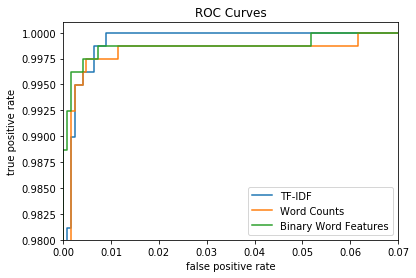

In [20]:
plt.plot(tfidf_fpr, tfidf_tpr, label="TF-IDF")
plt.plot(count_model_fpr, count_model_tpr, label="Word Counts")
plt.plot(binary_model_fpr, binary_model_tpr, label="Binary Word Features")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.98, 1.001])

plt.show()

## Modeling on Text in Practice

Most text modeling pipelines have a number of heuristic transforms used to reduce some of this noise.

Some issues that require thought in practical text mining settings:
* casing of words (upper vs lower)
* unique words / hashcodes / gibberish
* different character encodings
* accents, alternative characters for certain letters
* unique or very rare words
* punctuation and spacing: what is a "word"?
* bold/italicized/underlined words
* html or mime data is common. Usually just the raw text is extracted but the structure could be important. 
* dates or phone numbers (important but often unique)
* emojis
* urls (important, but should be parsed carefully, often unique) 


And thats just scratching the surface! Some of these can be handled by settings in sklearn's vectorizer classes, others must be handled by the data scientist themselves. Let's take a look at an example.

In [21]:
# first install some libraries
!sudo pip install --upgrade pip
!sudo pip uninstall -y html5lib
!sudo pip install --upgrade html5lib
!sudo pip install --upgrade html2text
!sudo pip install --upgrade chardet
!sudo pip install --upgrade lxml

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Requirement already up-to-date: pip in /usr/local/lib/python3.5/dist-packages
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Uninstalling html5lib-1.0.1:
  Successfully uninstalled html5lib-1.0.1
The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and th

In [22]:
# an example text modeling feature pipeline

import chardet
from html2text import html2text
import functools
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

def decode(content):
    # in prod settings, character encoding issues can be a huge pain!
    str_bytes = str.encode(content)
    charset = chardet.detect(str_bytes)['encoding']
    return str_bytes.decode(encoding=charset, errors='ignore')

def no_html(content):
    return html2text(content)

def tolower(content):
    return content.lower()

def cleaned_up(content):
    def apply_regex(x, regex_replacement):
        return re.sub(regex_replacement[0], regex_replacement[1], x)
      
    regexes = [
        (r"\|", " "),
        (r"\r\n?|\n", " "),
        (r"[^\x00-\x7F]+", " "),
        (r"\s+", " "),
        (r"\w{,20}[a-zA-Z]{1,20}[0-9]{1,20}", "_wn_"),
        (r"http\://\S+", "_url_"),
        (r"\d+/\d+/\d+", "_d2_"),
        (r"\d+/\d+", "_d_"),
        (r"\d+\-\d+-\d+", "_pn_"),
        (r":", " ")
    ]
    
    return functools.reduce(apply_regex, regexes, content)

def filter_long(content):
    return " ".join([y for y in content.split(" ") if len(y) <= 20])

def clean_all(X):
    return X\
        .apply(decode)\
        .apply(no_html)\
        .apply(tolower)\
        .apply(cleaned_up)\
        .apply(filter_long)

In [23]:
tfidf_vectorizer_clean = TfidfVectorizer(min_df=5,
                                         decode_error="ignore",
                                         ngram_range=(1,2))
X_train_clean = clean_all(X_train)
X_test_clean = clean_all(X_test)

tfidf_vectorizer_clean.fit(X_train_clean)

# Transform to a counter
X_train_tfidf_clean = tfidf_vectorizer.transform(X_train_clean)
X_test_tfidf_clean = tfidf_vectorizer.transform(X_test_clean)


clean_tfidf_model = LogisticRegression()
clean_tfidf_model.fit(X_train_tfidf_clean, y_train)

clean_tfidf_predictions = tfidf_model.predict_proba(X_test_tfidf_clean)[:,1]
clean_tfidf_auc = roc_auc_score(y_test, tfidf_predictions)

print ("Area under the ROC curve on test data = %.3f" % clean_tfidf_auc)

Area under the ROC curve on test data = 1.000


`features_pipeline_3` has capability to build these kinds of features auto-magically!

In [24]:
from ds_utils.features_pipeline_3 import pipeline_from_config

# this expects a pd dataframe so re-split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(spam_df, labels, train_size=0.75, test_size=0.25)

config = [
    {
        "field"        : "text",
        "transformers" : [{"name":"tfidf"}]
    }
]

pipeline = pipeline_from_config(config)
X_train_df_feats = pipeline.fit_transform(X_train_df)
X_test_df_feats = pipeline.transform(X_test_df)


clean_tfidf_model = LogisticRegression()
clean_tfidf_model.fit(X_train_df_feats, y_train_df)

df_tfidf_predictions = clean_tfidf_model.predict_proba(X_test_df_feats)[:,1]
df_tfidf_auc = roc_auc_score(y_test_df, df_tfidf_predictions)

print ("Area under the ROC curve on test data = %.3f" % df_tfidf_auc)

Area under the ROC curve on test data = 0.998
